In [61]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

In [62]:
train_file = os.getenv('HOME') + '/aiffel/datathon/train.csv'
test_file = os.getenv('HOME') + '/aiffel/datathon/test.csv'

df_train = pd.read_csv(train_file, encoding='cp949')
df_test = pd.read_csv(test_file, encoding='cp949')
# submission = pd.read_csv('../datathon/sample_submission.csv')

In [63]:
print(df_train.shape, df_test.shape)

(122400, 10) (10080, 9)


In [64]:
train = df_train.copy()
test = df_test.copy()

In [65]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.06,17.60,2.50,92.00,0.80,0.00,0.00,0.00
1,1,2020-06-01 01,8135.64,17.70,2.90,91.00,0.30,0.00,0.00,0.00
2,1,2020-06-01 02,8107.13,17.50,3.20,91.00,0.00,0.00,0.00,0.00
3,1,2020-06-01 03,8048.81,17.10,3.20,91.00,0.00,0.00,0.00,0.00
4,1,2020-06-01 04,8043.62,17.00,3.30,92.00,0.00,0.00,0.00,0.00


In [66]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.80,1.50,74.00,0.00,0.00,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.30,1.10,78.00,NaN,0.00,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# 한글 열 이름 변경
cols = ["num", "date_time", "energy", "temp", "windspeed", "humidity", "precipitation", "sun", "cooler", "solar"]
cols2 = ["num", "date_time", "temp", "windspeed", "humidity", "precipitation", "sun", "cooler", "solar"]


train.columns = cols
test.columns = cols2

In [68]:
train.head()

,num,date_time,energy,temp,windspeed,humidity,precipitation,sun,cooler,solar
0,1,2020-06-01 00,8179.06,17.60,2.50,92.00,0.80,0.00,0.00,0.00
1,1,2020-06-01 01,8135.64,17.70,2.90,91.00,0.30,0.00,0.00,0.00
2,1,2020-06-01 02,8107.13,17.50,3.20,91.00,0.00,0.00,0.00,0.00
3,1,2020-06-01 03,8048.81,17.10,3.20,91.00,0.00,0.00,0.00,0.00
4,1,2020-06-01 04,8043.62,17.00,3.30,92.00,0.00,0.00,0.00,0.00


In [69]:
test.head()

,num,date_time,temp,windspeed,humidity,precipitation,sun,cooler,solar
0,1,2020-08-25 00,27.80,1.50,74.00,0.00,0.00,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.30,1.10,78.00,NaN,0.00,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
for col in ['temp','windspeed','humidity','precipitation','sun']:
    test[col] = test[col].interpolate(method='linear')

pd.options.display.float_format = '{:.2f}'.format
test.head(10)

,num,date_time,temp,windspeed,humidity,precipitation,sun,cooler,solar
0,1,2020-08-25 00,27.80,1.50,74.00,0.00,0.00,NaN,NaN
1,1,2020-08-25 01,27.63,1.37,75.33,0.00,0.00,NaN,NaN
2,1,2020-08-25 02,27.47,1.23,76.67,0.00,0.00,NaN,NaN
3,1,2020-08-25 03,27.30,1.10,78.00,0.00,0.00,NaN,NaN
4,1,2020-08-25 04,26.90,1.17,79.67,0.00,0.00,NaN,NaN
5,1,2020-08-25 05,26.50,1.23,81.33,0.00,0.00,NaN,NaN
6,1,2020-08-25 06,26.10,1.30,83.00,0.00,0.00,NaN,NaN
7,1,2020-08-25 07,27.00,1.27,81.00,0.00,0.37,NaN,NaN
8,1,2020-08-25 08,27.90,1.23,79.00,0.00,0.73,NaN,NaN
9,1,2020-08-25 09,28.80,1.20,77.00,0.00,1.10,NaN,NaN


In [72]:
test = test.fillna(0)

In [84]:
test["cooler"].nunique(), test["solar"].nunique()

(2, 2)

In [73]:
test.head()

,num,date_time,temp,windspeed,humidity,precipitation,sun,cooler,solar
0,1,2020-08-25 00,27.80,1.50,74.00,0.00,0.00,0.00,0.00
1,1,2020-08-25 01,27.63,1.37,75.33,0.00,0.00,0.00,0.00
2,1,2020-08-25 02,27.47,1.23,76.67,0.00,0.00,0.00,0.00
3,1,2020-08-25 03,27.30,1.10,78.00,0.00,0.00,0.00,0.00
4,1,2020-08-25 04,26.90,1.17,79.67,0.00,0.00,0.00,0.00


In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num            122400 non-null  int64  
 1   date_time      122400 non-null  object 
 2   energy         122400 non-null  float64
 3   temp           122400 non-null  float64
 4   windspeed      122400 non-null  float64
 5   humidity       122400 non-null  float64
 6   precipitation  122400 non-null  float64
 7   sun            122400 non-null  float64
 8   cooler         122400 non-null  float64
 9   solar          122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [75]:
# date_time을 datetime으로 변환해주기

train["date_time"] = pd.to_datetime(train["date_time"])

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num            122400 non-null  int64         
 1   date_time      122400 non-null  datetime64[ns]
 2   energy         122400 non-null  float64       
 3   temp           122400 non-null  float64       
 4   windspeed      122400 non-null  float64       
 5   humidity       122400 non-null  float64       
 6   precipitation  122400 non-null  float64       
 7   sun            122400 non-null  float64       
 8   cooler         122400 non-null  float64       
 9   solar          122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


In [76]:
train["date"] = train["date_time"].dt.date # 전체 날짜
train["month"] = train["date_time"].dt.month # 월
train["day"] = train["date_time"].dt.day # 일
train["hour"] = train["date_time"].dt.hour
train["weekday"] = train["date_time"].dt.weekday # 0: 월요일
train["weekend"] = train["weekday"].isin([5, 6]).astype(int) # 5: 토요일

train.head()

,num,date_time,energy,temp,windspeed,humidity,precipitation,sun,cooler,solar,date,month,day,hour,weekday,weekend
0,1,2020-06-01 00:00:00,8179.06,17.60,2.50,92.00,0.80,0.00,0.00,0.00,2020-06-01,6,1,0,0,0
1,1,2020-06-01 01:00:00,8135.64,17.70,2.90,91.00,0.30,0.00,0.00,0.00,2020-06-01,6,1,1,0,0
2,1,2020-06-01 02:00:00,8107.13,17.50,3.20,91.00,0.00,0.00,0.00,0.00,2020-06-01,6,1,2,0,0
3,1,2020-06-01 03:00:00,8048.81,17.10,3.20,91.00,0.00,0.00,0.00,0.00,2020-06-01,6,1,3,0,0
4,1,2020-06-01 04:00:00,8043.62,17.00,3.30,92.00,0.00,0.00,0.00,0.00,2020-06-01,6,1,4,0,0


In [77]:
test["date_time"] = pd.to_datetime(test["date_time"])

In [78]:
test["date"] = test["date_time"].dt.date # 전체 날짜
test["month"] = test["date_time"].dt.month # 월
test["day"] = test["date_time"].dt.day # 일
test["hour"] = test["date_time"].dt.hour
test["weekday"] = test["date_time"].dt.weekday # 0: 월요일
test["weekend"] = test["weekday"].isin([5, 6]).astype(int) # 5: 토요일

test.head()

,num,date_time,temp,windspeed,humidity,precipitation,sun,cooler,solar,date,month,day,hour,weekday,weekend
0,1,2020-08-25 00:00:00,27.80,1.50,74.00,0.00,0.00,0.00,0.00,2020-08-25,8,25,0,1,0
1,1,2020-08-25 01:00:00,27.63,1.37,75.33,0.00,0.00,0.00,0.00,2020-08-25,8,25,1,1,0
2,1,2020-08-25 02:00:00,27.47,1.23,76.67,0.00,0.00,0.00,0.00,2020-08-25,8,25,2,1,0
3,1,2020-08-25 03:00:00,27.30,1.10,78.00,0.00,0.00,0.00,0.00,2020-08-25,8,25,3,1,0
4,1,2020-08-25 04:00:00,26.90,1.17,79.67,0.00,0.00,0.00,0.00,2020-08-25,8,25,4,1,0


---

In [79]:
train['THI'] = 1.8*train['temp'] - 0.55*(1-(train['humidity']/100))*(1.8*train['temp']-26) + 32
test['THI'] = 1.8*test['temp'] - 0.55*(1-(test['humidity']/100))*(1.8*test['temp']-26) + 32

train['sensible']=13.12+0.6215*train['temp']-13.947*train['windspeed']**0.16+0.486*train['temp']*train['windspeed']**0.1
test['sensible']=13.12+0.6215*test['temp']-13.947*test['windspeed']**0.16+0.486*test['temp']*test['windspeed']**0.1

---

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns

In [87]:
new_train = train.copy()
new_test = test.copy()

daily = train.groupby(['num','weekday'])['energy'].median().reset_index().pivot('num','weekday','energy').reset_index()
hourly = train.groupby(['num','hour'])['energy'].median().reset_index().pivot('num','hour','energy').reset_index().drop('num',axis = 1)
train_cluster = pd.concat([daily, hourly], axis= 1)

for i in range(len(train_cluster)):
    # 요일 별 전력 중앙값에 대해 scaling
    train_cluster.iloc[i,1:8] = (train_cluster.iloc[i,1:8] - train_cluster.iloc[i,1:8].mean())/train_cluster.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    train_cluster.iloc[i,8:] = (train_cluster.iloc[i,8:] - train_cluster.iloc[i,8:].mean())/train_cluster.iloc[i,8:].std()

kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(train_cluster.iloc[:,1:])

train_cluster['cluster'] = km_cluster
train_cluster['cluster'] = train_cluster['cluster'].map({0:1, 1:3, 2:2, 3:0})

new_train = new_train.merge(train_cluster[['num', 'cluster']], on = 'num', how = 'left')
new_test = new_test.merge(train_cluster[['num', 'cluster']], on = 'num', how = 'left')

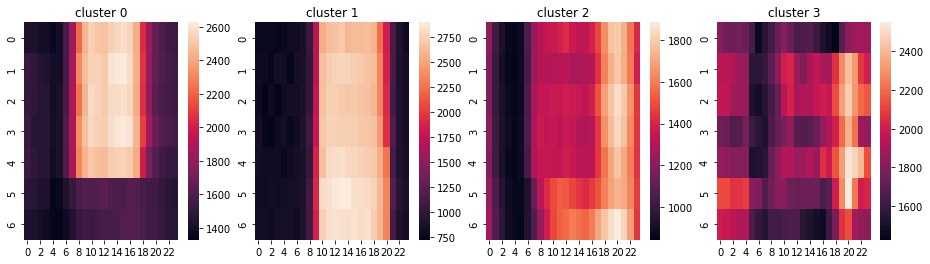

In [90]:
def draw_cluster(data):
    fig = plt.figure(figsize = (20, 4))
    for c in range(4):
        temp = data[data.cluster == c]
        temp = temp.groupby(['weekday', 'hour'])['energy'].median().reset_index().pivot('weekday', 'hour', 'energy')
        plt.subplot(1, 5, c+1)
        sns.heatmap(temp)
        plt.title(f'cluster {c}')
        plt.xlabel('')
        plt.ylabel('')
        
draw_cluster(new_train)

---

**Cluster의 전력사용량(kWh)과 기후 요소 상관관계**

In [94]:
type(new_train['cluster'][0])

numpy.int64

In [125]:
temp0 = new_train[new_train['cluster'] == 0].drop('cluster', axis = 1)[['energy','temp','windspeed','humidity','precipitation','sun']]
temp1 = new_train[new_train['cluster'] == 1].drop('cluster', axis = 1)[['energy','temp','windspeed','humidity','precipitation','sun']]
temp2 = new_train[new_train['cluster'] == 2].drop('cluster', axis = 1)[['energy','temp','windspeed','humidity','precipitation','sun']]
temp3 = new_train[new_train['cluster'] == 3].drop('cluster', axis = 1)[['energy','temp','windspeed','humidity','precipitation','sun']]

In [157]:
temp0.corrwith(temp0['energy'], method = 'spearman')

energy           1.00
temp             0.21
windspeed        0.09
humidity        -0.10
precipitation    0.00
sun              0.17
dtype: float64

In [158]:
temp1.corrwith(temp1['energy'])

energy           1.00
temp             0.25
windspeed        0.41
humidity        -0.02
precipitation   -0.03
sun              0.25
dtype: float64

In [159]:
temp2.corrwith(temp2['energy'])

energy           1.00
temp             0.47
windspeed       -0.02
humidity        -0.13
precipitation    0.00
sun              0.05
dtype: float64

In [160]:
temp3.corrwith(temp3['energy'], method = 'spearman')

energy           1.00
temp             0.09
windspeed        0.24
humidity        -0.04
precipitation   -0.00
sun             -0.01
dtype: float64

**요약**


|항목|Cluster 0|Cluster 1|Cluster 2|Cluster 3|
|:---:|:---:|:---:|:---:|:---:|
|기온(°C)|**0.21**|**0.25**|**0.47**|0.09|
|풍속(m/s)|0.09|**0.41**|-0.02|**0.24**|
|습도(%)|-0.10|-0.02|-0.13|-0.04|
|강수량(mm)|0.00|-0.03|0.00|-0.00|
|일조(hr)|0.17|**0.25**|0.05|0.01|

---